# VGG Network from Scratch in PyTorch

Building on the work of AlexNet, VGG focuses on another crucial aspect of Convolutional Neural Networks (CNNs), depth. VGG stands for the Vision Geometry Group from the University of Oxford. The VGG net is a Deep Learning model based on Convolutional Neural Networks (CNN) and defined in the paper "Very Deep Convolutional Networks for Large-Scale Image Recognition" (https://arxiv.org/abs/1409.1556).

In the paper, the authors introduced not one but six different network configurations for the VGG neural network models. Each of them has a different neural network architecture. The VGG-16 has 13 convolutional and 3 fully-connected layers, carrying with them the ReLU tradition from AlexNet. This network stacks more layers onto AlexNet, and use smaller size filters ($3 \times 3$ in conv modules and $2 \times 2$ in pooling modules). It consists of 138M parameters and takes up about 500MB of storage space. There is also a deeper variant, VGG-19, and the simplest of all the configurations, VGG-11.

In [1]:
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import inspect
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
device= 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# count how many trainable weights the model has
def count_parameters(model) -> None:
    total_params= sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'Number of parameters: {total_params}')

# Define configs for different VGG versions

In [4]:
# vgg_= (number of conv channels, norm presence, pool presence)
model_hparameters= {}
model_hparameters['vgg11']= (
    [64,128,256,256,512,512,512,512],  # Channels
    [1,1,1,1,1,1,1,1],                 # BatchNorm presence  (1 for yes, 0 for no)
    [1,1,0,1,0,1,0,1]                  # MaxPooling presence (1 for yes, 0 for no)
)
model_hparameters['vgg13']= (
    [64,64,128,128,256,256,512,512,512,512],
    [1]*10,
    [0,1,0,1,0,1,0,1,0,1]
)
model_hparameters['vgg16']= (
    [64,64,128,128,256,256,256,512,512,512,512,512,512],
    [1]*13,
    [0,1,0,1,0,0,1,0,0,1,0,0,1]
)
model_hparameters['vgg19']= (
    [64,64,128,128,256,256,256,256,512,512,512,512,512,512,512,512],
    [1]*16,
    [0,1,0,1,0,0,0,1,0,0,0,1,0,0,0,1]
)

# Define the Convolutional and Fully Connected Layers

- The convolutional layers will have a $3 \times 3$ kernel size with a stride of 1 and padding of 1.
- 2D max pooling in between the weight layers as explained in the paper. Not all the convolutional layers are followed by max-pooling layers.

In [5]:
class ConvLayer(nn.Module):
    """
    Implements one customizable CNN layer.
    VGG-style: Input -> Conv2d -> BatchNorm2d -> ReLU -> MaxPool2d -> Output
    """

    def __init__(self, in_channels, out_channels, norm=True, activation=None, pool=True) -> None:
        super(ConvLayer, self).__init__()
        self.conv= nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        # Batch Normalization -- not introduced when VGG models came out
        self.norm= nn.BatchNorm2d(out_channels) if norm else None
        # Activation function -- ReLU is the default in VGG
        self.activation= nn.ReLU(inplace=True) if activation is None else activation
        # Max pooling layer -- halves the feature maps each time
        self.pool= nn.MaxPool2d(kernel_size=2, stride=2) if pool else None


    def forward(self, x):
        x= self.conv(x)
        if self.norm is not None:
            x= self.norm(x)
        x= self.activation(x)
        if self.pool is not None:
            x= self.pool(x)

        return x


In [6]:
class MLPLayer(nn.Module):
    """
    Implements one customizable MLP layer.
    AlexNet/VGG-style: Input -> Dropout -> Linear -> ReLU -> Output
    Dropout is placed before the FC layer
    """

    def __init__(self, in_dim, out_dim, activation=None, dropout=0.0) -> None:
        super(MLPLayer, self).__init__()
        # Dropout layer for regularization
        self.dropout= nn.Dropout(p=dropout) if dropout> 0.0 else None
        # Fully connected (FC) layer
        self.fc= nn.Linear(in_dim, out_dim)
        # Activation function -- ReLU is the default in VGG
        self.activation= activation  # for the final layer: activation=None


    def forward(self, x):
        if self.dropout is not None:
            x= self.dropout(x)
        x= self.fc(x)
        if self.activation is not None:
            x= self.activation(x)

        return x


# Building the VGG

The in_channels and num_classes hyperparameters are the number of color channels for the image and the number of output classes for the dataset. We have to pass the number of channels while initializing the VGG model depending upon the type of images that we are using. It is going to be 3 for RGB images and 1 for grayscale images. And as the original VGG models were benchmarked on the ImageNet dataset with 1000 classes, therefore, num_classes is 1000 as well.

- Each convolutional layer is followed by an activation but the max-pooling layers are not defined after each convolution. The max-pooling layers to going to halve the feature maps each time. And we have 5 such max-pooling layers with a stride of 2. This is going to be important when we will be implementing the fully connected layers.

- The fully connected blocks are the same for all the VGG architectures. They contain three fully connected layers. The first linear layer has $512*7*7$ input features. But how did we reach here? Note that VGG takes an input size of 224 $\times 224$ (height $\times$ width) for images. And we have 5 max-pool layers with a stride of 2 which are going to halve the features maps each time. Also, the final convolutional layer has 512 output channels. To get the number of input features for the first Linear() layer, we just need to calculate it using the following formula: $224 / (2^5) = 7$. And because the final convolutional layer has 512 output channels, the first linear layer has $512*7*7$ input features.

In [7]:
class VGG(nn.Module):
    """
    VGG architecture that builds the feature extractor based on the provided variant.
    """

    def __init__(self, vgg_type, in_channels, num_classes, activation=None, dropout=0.1) -> None:
        super(VGG, self).__init__()
        # Channels along with BatchNorm2d and MaxPool2d presence for each ConvLayer
        channels= vgg_type[0]
        norms   = vgg_type[1]
        maxpools= vgg_type[2]
        # Define the activation function -- ReLU is the default in VGG
        activation= nn.ReLU(inplace=True) if activation is None else activation

        # The convolutional feature extractor
        self.conv_layers= nn.ModuleList([
            ConvLayer(in_channels, channels[0], norms[0], activation, maxpools[0])
        ])
        for i in range(1, len(channels)):
            self.conv_layers.append(
                ConvLayer(channels[i-1], channels[i], norms[i], activation, maxpools[i])
            )
        # Flatten the 2D feature maps into 1D feature vectors
        self.flatten= nn.Flatten(start_dim=1)

        # The classification head -- FC linear layers
        self.fc = MLPLayer(7*7*512, 4096, activation, dropout)
        self.fc1= MLPLayer(4096, 4096, activation, dropout)
        self.fc2= MLPLayer(4096, num_classes, activation=None, dropout=0.0)

        # initialize parameters with Xavier initialization
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None: nn.init.zeros_(m.bias)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1.0)
                nn.init.constant_(m.bias, 0.0)


    def forward(self, x):
        # Processes the input through the convolutional layers
        for layer in self.conv_layers:
            x= layer(x)
        x= self.flatten(x)
        # Runs the feature vector through the classification head to generate predictions
        x= self.fc(x)
        x= self.fc1(x)

        return self.fc2(x)


In [8]:
img= torch.randn(1, 3, 224, 224).to(device)  # a single image batch
model= VGG(model_hparameters['vgg16'], in_channels=3, num_classes=1000, dropout=0.1).to(device)
count_parameters(model)
print(model(img).shape)

model

Number of parameters: 138365992
torch.Size([1, 1000])


VGG(
  (conv_layers): ModuleList(
    (0): ConvLayer(
      (conv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
    (1): ConvLayer(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ConvLayer(
      (conv): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU(inplace=True)
    )
    (3): ConvLayer(
      (conv): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): BatchNorm2d(128, eps=1e-05, momentum=0.1, a

# Training a VGG model from scratch

In [9]:
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

In [10]:
# data preparation -- define transformations for the dataset
transform= transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465],
                         std= [0.2023, 0.1994, 0.2010]), # CIFAR-10 stats
])

# load the CIFAR-10 dataset
train_dataset= datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False,download=True, transform=transform)

# create data loaders
train_size= int(0.9 * len(train_dataset))
val_size  = len(train_dataset) - train_size
train_dataset, val_dataset= random_split(train_dataset, [train_size, val_size])

batch_size= 128
train_loader= DataLoader(train_dataset,batch_size=batch_size, shuffle=True)
val_loader  = DataLoader(val_dataset,  batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [11]:
len(train_loader), len(val_loader)

(352, 40)

# Trainer Function

TODO:

- Data augmentation for training.
- Logging Learning Rate.
- Early Stopping: based on validation loss to prevent overfitting.

In [12]:
def trainer(model, train_loader, val_loader, optimizer, criterion, scheduler, epochs,
            device, eval_interval=1, verbose=False):

    tr_loss_hist= []
    vl_loss_hist= []

    # --- training loop ---
    for epoch in range(epochs):
        model.train()
        batch_loss= []
        start= time.time()

        # --- training steps ---
        # iterating over all batches
        for step, (images, labels) in enumerate(train_loader):
            # --- minibatch construction ---
            images= images.to(device, non_blocking=True)
            labels= labels.to(device, non_blocking=True)

            # --- forward pass and get loss ---
            logits= model(images)
            loss= criterion(logits, labels)
            batch_loss.append(loss.item())

            # --- backward pass to calculate the gradients ---
            optimizer.zero_grad()
            loss.backward()

            # --- update the parameters using the gradient ---
            optimizer.step()

        # --- evaluation and track stats ---
        tr_loss_hist.append(np.mean(batch_loss))

        if epoch% eval_interval== 0 or epoch== epochs-1:
            model.eval()
            val_loss= []
            with torch.no_grad():
                for images, labels in val_loader:
                    images, labels= images.to(device), labels.to(device)
                    logits= model(images)
                    loss_v= criterion(logits, labels)
                    val_loss.append(loss_v.item())

            val_loss= np.mean(val_loss)
            end= time.time()
            dt= end - start

            if verbose:
                print(f"Epoch: {epoch} | Train Loss: {tr_loss_hist[-1]:.4f} | "
                      f"Val Loss: {val_loss:.4f} | dt/epoch: {dt*1000:.2f}ms")

            # for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
            scheduler.step(val_loss)

        vl_loss_hist.append(val_loss)

    return tr_loss_hist, vl_loss_hist


In [13]:
def evaluate_model(model, test_loader, device, verbose=False):
    model.eval()
    correct= 0
    total= 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels= images.to(device), labels.to(device)
            logits= model(images)
            y_pred= torch.argmax(logits, dim=1)
            correct += (y_pred == labels).sum().item()
            total += labels.size(0)

    acc= correct / total
    if verbose:
        print(f"Accuracy: {(acc * 100):.2f}%")

    return acc


In [14]:
def plot_losses(train_loss, valid_loss):
    # plot training and validation losses
    plt.plot(train_loss, label='Train Loss')
    plt.plot(valid_loss, label='Validation Loss')
    plt.title('Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

# Training setup using TF32 and Fused AdamW

In [15]:
use_fused= False

if device== 'cuda': # TF32 computationally more efficient (slightly the same precision of FP32)
    torch.set_float32_matmul_precision('high')
    # create AdamW optimizer and use the fused version of it is available
    fused_available= 'fused' in inspect.signature(torch.optim.AdamW).parameters
    # fused is a lot faster when it is available and when running on cuda
    use_fused= fused_available

# --- VGG16 ---
in_channels= 3
num_classes= 10

model= VGG(model_hparameters['vgg16'], in_channels, num_classes, dropout=0.1).to(device)
count_parameters(model)


# train_loader has size 352, so 20 epochs have 7,040 steps
epochs= 20
learning_rate= 1e-3

optimizer= torch.optim.AdamW(
    model.parameters(), lr=learning_rate, betas=(0.9, 0.999), weight_decay=1e-4,
    fused=use_fused
)
print(f"Using fused AdamW: {use_fused}")
criterion= nn.CrossEntropyLoss()
# for decreasing learning rate -- the ReduceLROnPlateau is designed to be used per epoch
scheduler= ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, min_lr=1e-6)

Number of parameters: 134309962
Using fused AdamW: True


In [16]:
tr_loss, vl_loss= trainer(model, train_loader, val_loader, optimizer, criterion, scheduler,
                          epochs, device, verbose=True)

Epoch: 0 | Train Loss: 3.5384 | Val Loss: 1.7945 | dt/epoch: 113592.17ms
Epoch: 1 | Train Loss: 1.7617 | Val Loss: 1.6133 | dt/epoch: 113076.92ms
Epoch: 2 | Train Loss: 1.6090 | Val Loss: 1.4614 | dt/epoch: 113070.77ms
Epoch: 3 | Train Loss: 1.4942 | Val Loss: 1.3378 | dt/epoch: 112968.97ms
Epoch: 4 | Train Loss: 1.3244 | Val Loss: 1.1782 | dt/epoch: 113077.20ms
Epoch: 5 | Train Loss: 1.1878 | Val Loss: 1.1805 | dt/epoch: 112910.53ms
Epoch: 6 | Train Loss: 1.0905 | Val Loss: 1.0183 | dt/epoch: 113096.68ms
Epoch: 7 | Train Loss: 0.9880 | Val Loss: 0.9506 | dt/epoch: 113186.84ms
Epoch: 8 | Train Loss: 0.8832 | Val Loss: 0.8524 | dt/epoch: 113098.28ms
Epoch: 9 | Train Loss: 0.8060 | Val Loss: 0.9087 | dt/epoch: 113202.71ms
Epoch: 10 | Train Loss: 0.7912 | Val Loss: 0.7952 | dt/epoch: 113098.78ms
Epoch: 11 | Train Loss: 0.7876 | Val Loss: 0.8645 | dt/epoch: 113210.40ms
Epoch: 12 | Train Loss: 0.6910 | Val Loss: 0.6350 | dt/epoch: 113040.39ms
Epoch: 13 | Train Loss: 0.6119 | Val Loss: 0.912

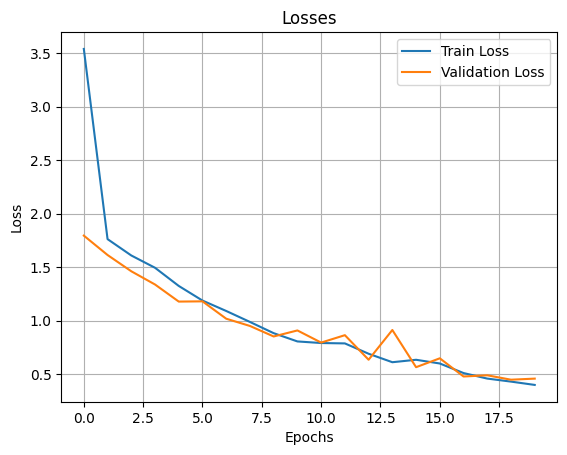

In [17]:
# plot
plot_losses(tr_loss, vl_loss)

In [18]:
vgg_acc= evaluate_model(model, test_loader, device, verbose=True)

Accuracy: 83.20%


In [ ]:
# https://medium.com/@ilaslanduzgun/create-vgg-from-scratch-in-pytorch-aa194c269b55
# https://www.digitalocean.com/community/tutorials/vgg-from-scratch-pytorch
# https://debuggercafe.com/implementing-vgg11-from-scratch-using-pytorch/